In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
URL='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip'
ZIP_FILE='./datasets/horse2zebra.zip'
TARGET_DIR='./datasets/horse2zebra'
!mkdir -p ./datasets
!wget -N $URL -O $ZIP_FILE
!unzip $ZIP_FILE -d ./datasets/
!rm $ZIP_FILE

# Adapt to project expected directory heriarchy
!mkdir -p "$TARGET_DIR/train" "$TARGET_DIR/test"
!mv "$TARGET_DIR/trainA" "$TARGET_DIR/train/A"
!mv "$TARGET_DIR/trainB" "$TARGET_DIR/train/B"
!mv "$TARGET_DIR/testA" "$TARGET_DIR/test/A"
!mv "$TARGET_DIR/testB" "$TARGET_DIR/test/B"

for details.

--2023-05-25 16:37:06--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  44.6MB/s    in 2.5s    

2023-05-25 16:37:09 (44.6 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3001.jp

In [2]:
import glob
import random
import os
import time
import datetime
import sys

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import numpy as np

import argparse
import itertools

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=30, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=6, help='size of the batches')   # paper과 다름 (colab 환경...)
parser.add_argument('--dataroot', type=str, default='datasets/horse2zebra/', help='root directory of the dataset')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=5, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=128, help='size of the data crop (squared assumed)')   # paper과 다름 (colab 환경...)
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--cuda', action='store_false', help='use GPU computation')  # cuda를 이용함
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')  # paper과 다름 - (colab 환경... 최대 2개까지 사용 권장..)
opt = parser.parse_args('')
print(opt)

Namespace(epoch=0, n_epochs=30, batchSize=6, dataroot='datasets/horse2zebra/', lr=0.0002, decay_epoch=5, size=128, input_nc=3, output_nc=3, cuda=True, n_cpu=8)


In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert("RGB"))  ## gray Channel의 image --> RGB channel image로 변환

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert("RGB"))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert("RGB"))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.ReflectionPad2d(1),                # 64 -> 66
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1),    # 66 -> 64
            nn.InstanceNorm2d(out_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),      # 64 -> 66
            nn.Conv2d(in_channels=out_features, out_channels=out_features, kernel_size=3, stride=1),    # 66 -> 64
            nn.InstanceNorm2d(out_features)
        )
    
    def forward(self, x):
        return x + self.residual(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=6):
        super(Generator, self).__init__()

        model = []
        ###  Generator Model  ###
        # Encoder block 
        model += [  
            self.generative_block("en", input_nc, 64, 7, 1),    # 256 -> 262 -> 256
            self.generative_block("en", 64, 128, 3, 2),         # 256 -> 128
            self.generative_block("en", 128, 256, 3, 2)         # 128 -> 64
        ] 
            

        # Residual block
        model += [ResidualBlock(in_features=256, out_features=256)] * n_residual_blocks    # 64 -> 64

        # Decoder block
        model += [
            self.generative_block("de", 256, 128, 3, 2),    # 64 -> 128
            self.generative_block("de", 128, 64, 3, 2),     # 128 -> 256
            self.generative_block("de", 64, 3, 7, 1),       # 256 -> 256
        ]

        self.model = nn.Sequential(*model)

    def generative_block(self, k, in_ch, out_ch, ksize, stride):
      gen_block = []

      ## Encoder인 경우
      if k == "en":
        # c7s1-64
        if in_ch == 3:
          gen_block.append(nn.ReflectionPad2d(3)) 
          gen_block.append(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ksize, stride=stride, bias=False))
                                               
        else:
          gen_block.append(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ksize, stride=stride, padding=1,  bias=False))

        gen_block.append(nn.InstanceNorm2d(num_features=out_ch))
        gen_block.append(nn.ReLU(inplace=True))

      ## Decoder인 경우  
      else:
        # c7s1-3
        if out_ch == 3:
          gen_block.append(nn.ReflectionPad2d(3))
          gen_block.append(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ksize, stride=stride))
          gen_block.append(nn.Tanh())

        else:
          gen_block.append(nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ksize, padding=1, output_padding=1, stride=stride, bias=False))
          ## output_padding=1을 해줘야 shape이 맞음
          ## ex. Conv2d는 kernel_size=3, stride=2인 경우, [1,7,7]과 [1,8,8]의 shape을 가진 image는 모두 [1,3,3]으로 처리함
          ##     하지만 ConvTranspose2d가 kernel_size=3, stride=2인 경우, 기존 이미지가 [1,7,7]인지 [1,8,8]인지 모호함
          ##  이런 경우에 output_padding=1을 설정해주면 [1,8,8]으로, default는 [1,7,7]로 업샘플링을 진행함

          gen_block.append(nn.InstanceNorm2d(num_features=out_ch))
          gen_block.append(nn.ReLU(inplace=True))
        
      return nn.Sequential(*gen_block)
      
      
    def forward(self, x):
      return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        # Discriminator Model
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_nc, out_channels=64, kernel_size=4, stride=2),
            nn.LeakyReLU(negative_slope=0.2),           ## paper : C-64에는 InstanceNorm2d를 적용하지 않음
            self.discriminator_block(64, 128),
            self.discriminator_block(128, 256),
            self.discriminator_block(256, 512),
            nn.Conv2d(in_channels=512, out_channels=3, kernel_size=4, stride=1),
            nn.Sigmoid()
        )
            
    def discriminator_block(self, in_ch, out_ch):
      discriminator_block = [
          nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4, stride=2),
          nn.InstanceNorm2d(out_ch),
          nn.LeakyReLU(negative_slope=0.2)
      ]
      return nn.Sequential(*discriminator_block)

    def forward(self, x):
      x =  self.model(x)
      # Average pooling and flatten
      return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [6]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [7]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [9]:
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

<ipython-input-8-bc8a8e09f300>:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 3, kernel_size=(4, 4), stride=(1, 1))
    (6): Sigmoid()
  )
)

In [10]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)


In [11]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_A_ = Tensor(2, opt.input_nc, opt.size, opt.size)

input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
input_B_ = Tensor(2, opt.output_nc, opt.size, opt.size)

target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [12]:
# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

dataset = ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize, shuffle=True, num_workers=2)

In [13]:
###### Training ######
step_num = len(dataloader)
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        if i == step_num -1 :  ## data의 수가 batch size로 나눴을 때, 딱맞아 떨어지지 않음 // 나머지 데이터의 수에 맞춰 조절
          real_A = Variable(input_A_.copy_(batch['A']))  
          real_B = Variable(input_B_.copy_(batch['B']))
        
        else:
          real_A = Variable(input_A.copy_(batch['A']))
          real_B = Variable(input_B.copy_(batch['B'])) 
    
        real_label = Variable(Tensor(np.ones((real_A.size(0), 3))), requires_grad=False)
        fake_label = Variable(Tensor(np.zeros((real_A.size(0), 3))), requires_grad=False)

                ###################################


        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        ##### Identity loss (lambda=5) #####
        # G_A2B(B) should equal B if real B is fed     
        lambda_i = 5
        loss_identity_B = lambda_i * criterion_identity(netG_A2B(real_B), real_B)
        
        # G_B2A(A) should equal A if real A is fed
        loss_identity_A = lambda_i * criterion_identity(netG_B2A(real_A), real_A)

        ##### GAN loss (lambda=1) ##### 
        lambda_g = 1
        fake_B = netG_A2B(real_A)
        fake_A = netG_B2A(real_B)
        
        loss_GAN_A2B= lambda_g * criterion_GAN(netD_B(fake_B), real_label)
        loss_GAN_B2A= lambda_g * criterion_GAN(netD_A(fake_A), real_label)

        #####  Cycle loss (lambda=10) ##### 
        lambda_c = 10
        loss_cycle_ABA= lambda_c * criterion_cycle(netG_B2A(fake_B), real_A)
        loss_cycle_BAB= lambda_c * criterion_cycle(netG_A2B(fake_A), real_B)

        #####  Total loss ##### 
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()


                ###################################


        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        loss_real_A = criterion_GAN(netD_A(real_A), real_label)

        # Fake loss
        loss_fake_A = criterion_GAN(netD_A(fake_A.detach()),fake_label)

        # Total loss
        loss_D_A = (loss_real_A + loss_fake_A)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        
        ###################################


        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        loss_real_B= criterion_GAN(netD_B(real_B), real_label)

        # Fake loss
        loss_fake_B = criterion_GAN(netD_B(fake_B.detach()),fake_label)

        # Total loss
        loss_D_B = (loss_real_B + loss_fake_B)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################  

        # if (i+1) % 25 == 0:
    print('Epoch [{}/{}], D_A_loss: {:.4f}, D_B_loss: {:.4f}, G_loss: {:.4f}'
    .format(epoch, opt.n_epochs, loss_D_A.item(), loss_D_B.item(), loss_G.item()))

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), '/content/drive/MyDrive/dl/cycleGAN/result/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), '/content/drive/MyDrive/dl/cycleGAN/result/netG_B2A.pth')
    torch.save(netD_A.state_dict(), '/content/drive/MyDrive/dl/cycleGAN/result/netD_A.pth')
    torch.save(netD_B.state_dict(), '/content/drive/MyDrive/dl/cycleGAN/result/netD_B.pth')
###################################

Epoch [0/30], D_A_loss: 0.2473, D_B_loss: 0.3404, G_loss: 6.3744
Epoch [1/30], D_A_loss: 0.2764, D_B_loss: 0.2721, G_loss: 5.9704
Epoch [2/30], D_A_loss: 0.0970, D_B_loss: 0.0547, G_loss: 7.1913
Epoch [3/30], D_A_loss: 0.1690, D_B_loss: 0.1528, G_loss: 7.1325
Epoch [4/30], D_A_loss: 0.2108, D_B_loss: 0.1828, G_loss: 10.1090
Epoch [5/30], D_A_loss: 0.1174, D_B_loss: 0.2995, G_loss: 6.7348
Epoch [6/30], D_A_loss: 0.0650, D_B_loss: 0.1589, G_loss: 5.1790
Epoch [7/30], D_A_loss: 0.1598, D_B_loss: 0.0819, G_loss: 6.1992
Epoch [8/30], D_A_loss: 0.1544, D_B_loss: 0.0316, G_loss: 7.3424
Epoch [9/30], D_A_loss: 0.2453, D_B_loss: 0.1147, G_loss: 5.6725
Epoch [10/30], D_A_loss: 0.2221, D_B_loss: 0.1421, G_loss: 6.0490
Epoch [11/30], D_A_loss: 0.3666, D_B_loss: 0.2079, G_loss: 5.5730
Epoch [12/30], D_A_loss: 0.1954, D_B_loss: 0.1760, G_loss: 4.6177
Epoch [13/30], D_A_loss: 0.2242, D_B_loss: 0.1198, G_loss: 5.0099
Epoch [14/30], D_A_loss: 0.0774, D_B_loss: 0.2197, G_loss: 7.4335
Epoch [15/30], D_A_

In [19]:
###### Testing######

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]

testDataset = ImageDataset(opt.dataroot, transforms_=transforms_, mode='test')
dataloader = DataLoader(testDataset, batch_size=opt.batchSize, shuffle=False, num_workers=2)

In [16]:
# Create output dirs if they don't exist
if not os.path.exists('/content/drive/MyDrive/dl/cycleGAN/result/fake/A'):
    os.makedirs('/content/drive/MyDrive/dl/cycleGAN/result/fake/A')
if not os.path.exists('/content/drive/MyDrive/dl/cycleGAN/result/fake/B'):
    os.makedirs('/content/drive/MyDrive/dl/cycleGAN/result/fake/B')

In [20]:
step_num = len(dataloader)
for i, batch in enumerate(dataloader):
    # Set model input
    if i == step_num -1 :
      real_A = Variable(input_A_.copy_(batch['A']))
      real_B = Variable(input_B_.copy_(batch['B']))
        
    else:
      real_A = Variable(input_A.copy_(batch['A']))
      real_B = Variable(input_B.copy_(batch['B'])) 

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, '/content/drive/MyDrive/dl/cycleGAN/result/fake/A/%04d.png' % (i+1))
    save_image(fake_B, '/content/drive/MyDrive/dl/cycleGAN/result/fake/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')

Generated images 0024 of 0024


In [26]:
import PIL
import glob
import matplotlib.pyplot as plt

def view_image(path):
  img = PIL.Image.open(path)
  tf = transforms.ToTensor()
  img_t = tf(img)
  img_t = img_t.permute(1,2,0)
  return img_t

--------------------------------------------------  fake images A  --------------------------------------------------


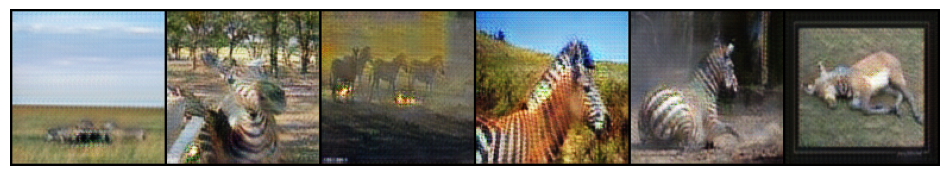

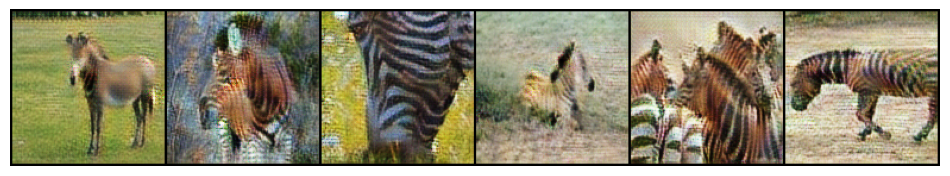

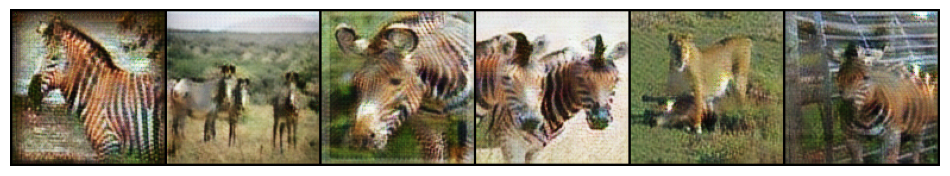

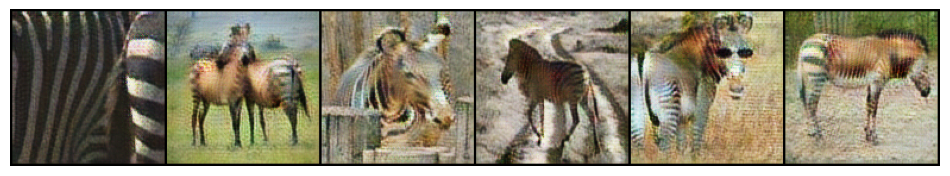

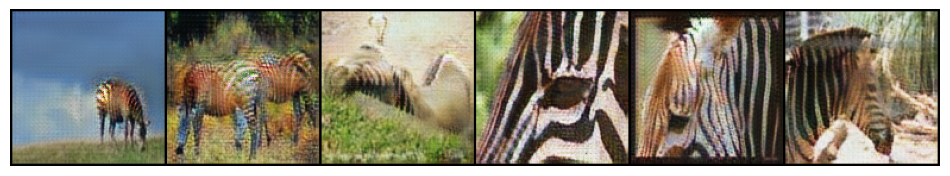

--------------------------------------------------  fake images B  --------------------------------------------------


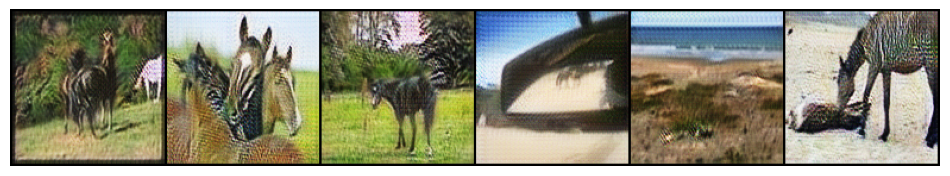

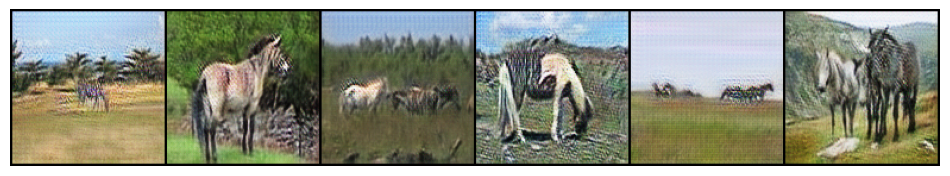

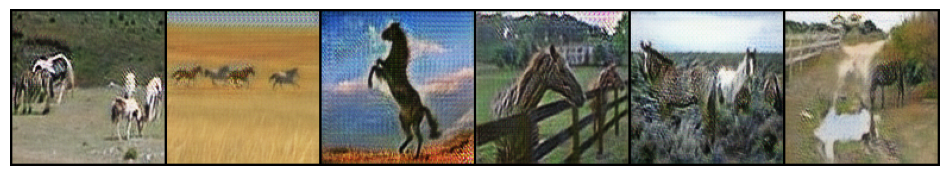

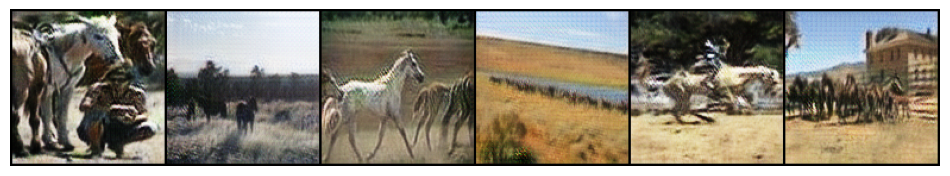

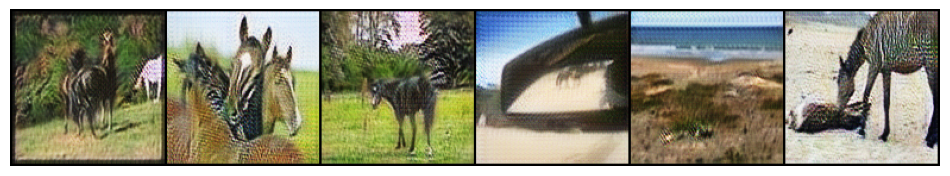

In [28]:
fake_A_path = glob.glob('/content/drive/MyDrive/dl/cycleGAN/result/fake/A/*.png')
fake_B_path = glob.glob('/content/drive/MyDrive/dl/cycleGAN/result/fake/B/*.png')

print( "-"*50, " fake images A ", "-"*50)
for i in range(0,len(fake_A_path),5):
  plt.figure(figsize=(12,8))
  plt.imshow(view_image(fake_A_path[i]))
  plt.axis("off")
  plt.show()

print( "-"*50, " fake images B ", "-"*50)
for i in range(0,len(fake_B_path),5):
  plt.figure(figsize=(12,8))
  plt.imshow(view_image(fake_B_path[i]))
  plt.axis("off")
  plt.show()